# Data Analysis and Preprocessing
In this first notebook, we will take a look at some [publically available data for supermarket sales](https://www.kaggle.com/datasets/aungpyaeap/supermarket-sales) and attempt to perform Exploratory Data Analysis (EDA) to figure out a strategy to perform sales forecasting. 

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.style.use('ggplot')

# Load the dataset, present in the /data folder
BASE_DIR = Path("data_analysis_preprocessing.ipynb").resolve(strict = True).parent.parent
data = pd.read_csv(BASE_DIR / "data/sales.csv")

data.head(5)

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


## Exploratory Data Analysis
To make sense of our data, we will perform both Univariate EDA (assuming independent data-columns) and multivariate EDA (assuming some innate correlation between data). To this end, significant visualization will be done using matplotlib/seaborn on a pandas dataframe (DF).

### Data preparation
An important step, before jumping into EDA, is to make sure the data is neatly formatted and descriptive of our problem. Some basic data maintenance is then required:

In [75]:
# Get a general description of the data
data.describe()

,Unit price,Quantity,Tax 5%,Total,cogs,gross margin percentage,gross income,Rating
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1.000000e+03,1000.000000,1000.00000
mean,55.672130,5.510000,15.379369,322.966749,307.58738,4.761905e+00,15.379369,6.97270
std,26.494628,2.923431,11.708825,245.885335,234.17651,6.131498e-14,11.708825,1.71858
min,10.080000,1.000000,0.508500,10.678500,10.17000,4.761905e+00,0.508500,4.00000
25%,32.875000,3.000000,5.924875,124.422375,118.49750,4.761905e+00,5.924875,5.50000
50%,55.230000,5.000000,12.088000,253.848000,241.76000,4.761905e+00,12.088000,7.00000
75%,77.935000,8.000000,22.445250,471.350250,448.90500,4.761905e+00,22.445250,8.50000
max,99.960000,10.000000,49.650000,1042.650000,993.00000,4.761905e+00,49.650000,10.00000


Firstly, let us drop all columns not deemed worthwhile for a time series forecasting:

In [76]:
# Drop columns that are not deemed interesting for the time series forecasting
data = data[[#'Invoice ID', 
        'Branch', 'City', 
        #'Customer type', 
        'Gender',
        'Product line', 
        'Unit price', 
        'Quantity', 
        #'Tax 5%', 
        'Total', 
        'Date',
        #'Time', 
        #'Payment', 
        'cogs', 
        #'gross margin percentage', 
        'gross income',
        #'Rating'
        ]].copy()

data.head(5)

,Branch,City,Gender,Product line,Unit price,Quantity,Total,Date,cogs,gross income
0,A,Yangon,Female,Health and beauty,74.69,7,548.9715,1/5/2019,522.83,26.1415
1,C,Naypyitaw,Female,Electronic accessories,15.28,5,80.2200,3/8/2019,76.40,3.8200
2,A,Yangon,Male,Home and lifestyle,46.33,7,340.5255,3/3/2019,324.31,16.2155
3,A,Yangon,Male,Health and beauty,58.22,8,489.0480,1/27/2019,465.76,23.2880
4,A,Yangon,Male,Sports and travel,86.31,7,634.3785,2/8/2019,604.17,30.2085


Secondly, let us clean up datatypes so all data is formatted correctly:

In [77]:
# Change date to datetime-format
data["Date"] = pd.to_datetime(data['Date'])

### Univariate EDA
Let us inspect the columns independently, to see what knowledge we can extrapolate. Firstly, let us consider the amount of each `product line` sold across all stores and their respective `quantities`:

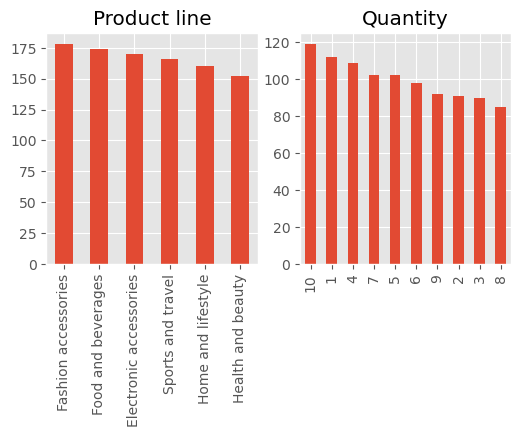

In [78]:
# Print the counts of values for the product lines and qualities:
columns_of_interest = ["Product line", "Quantity"]  # columns of interest
n = len(columns_of_interest)

# Plot barplots in order as subplots of a figure
fig = plt.figure(figsize = (3*n, 3))
for i, col in enumerate(columns_of_interest):
    plt.subplot(1, n, i+1)
    data[col].value_counts().plot(kind='bar')
    plt.title(col)

plt.show()

It is evident here that both products sold and the amount are fairly uniform. Note in the `quantity`-column that items are most frequently sold in the greatest or smallest quantity, yielding no information on its own.

Let us now consider a set of histograms for the total cost per item (unit price*quantity + 5% tax) and the gross income of all sales (total - cost of all items): 

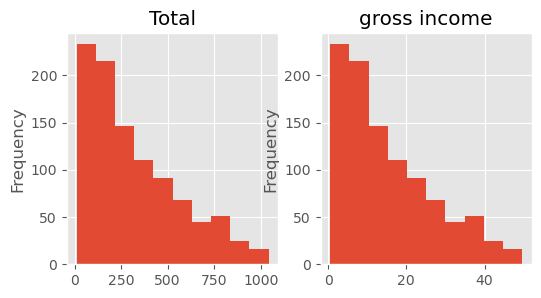

In [79]:
# Print histograms for the total amount paid by the customer and the gross income
columns_of_interest = ["Total", "gross income"]
n = len(columns_of_interest)

# Plot the histograms in order as subplots of a figure
fig = plt.figure(figsize = (3*n, 3))
for i, col in enumerate(columns_of_interest):
    plt.subplot(1, n, i+1)
    data[col].plot(kind='hist')
    plt.title(col)

plt.show()

Comparatively, here it is evident that the total paid and gross income are heavily scewed metrics. This might have to be taken into consideration later on.

## Multivariate EDA
More importantly, we want to see how data-values correlate to one another. A great way to do this is with a `sns.pairplot()`. This essentially plots a selection of data against one another in a grid, allowing for some quick, initial analysis of correlations:

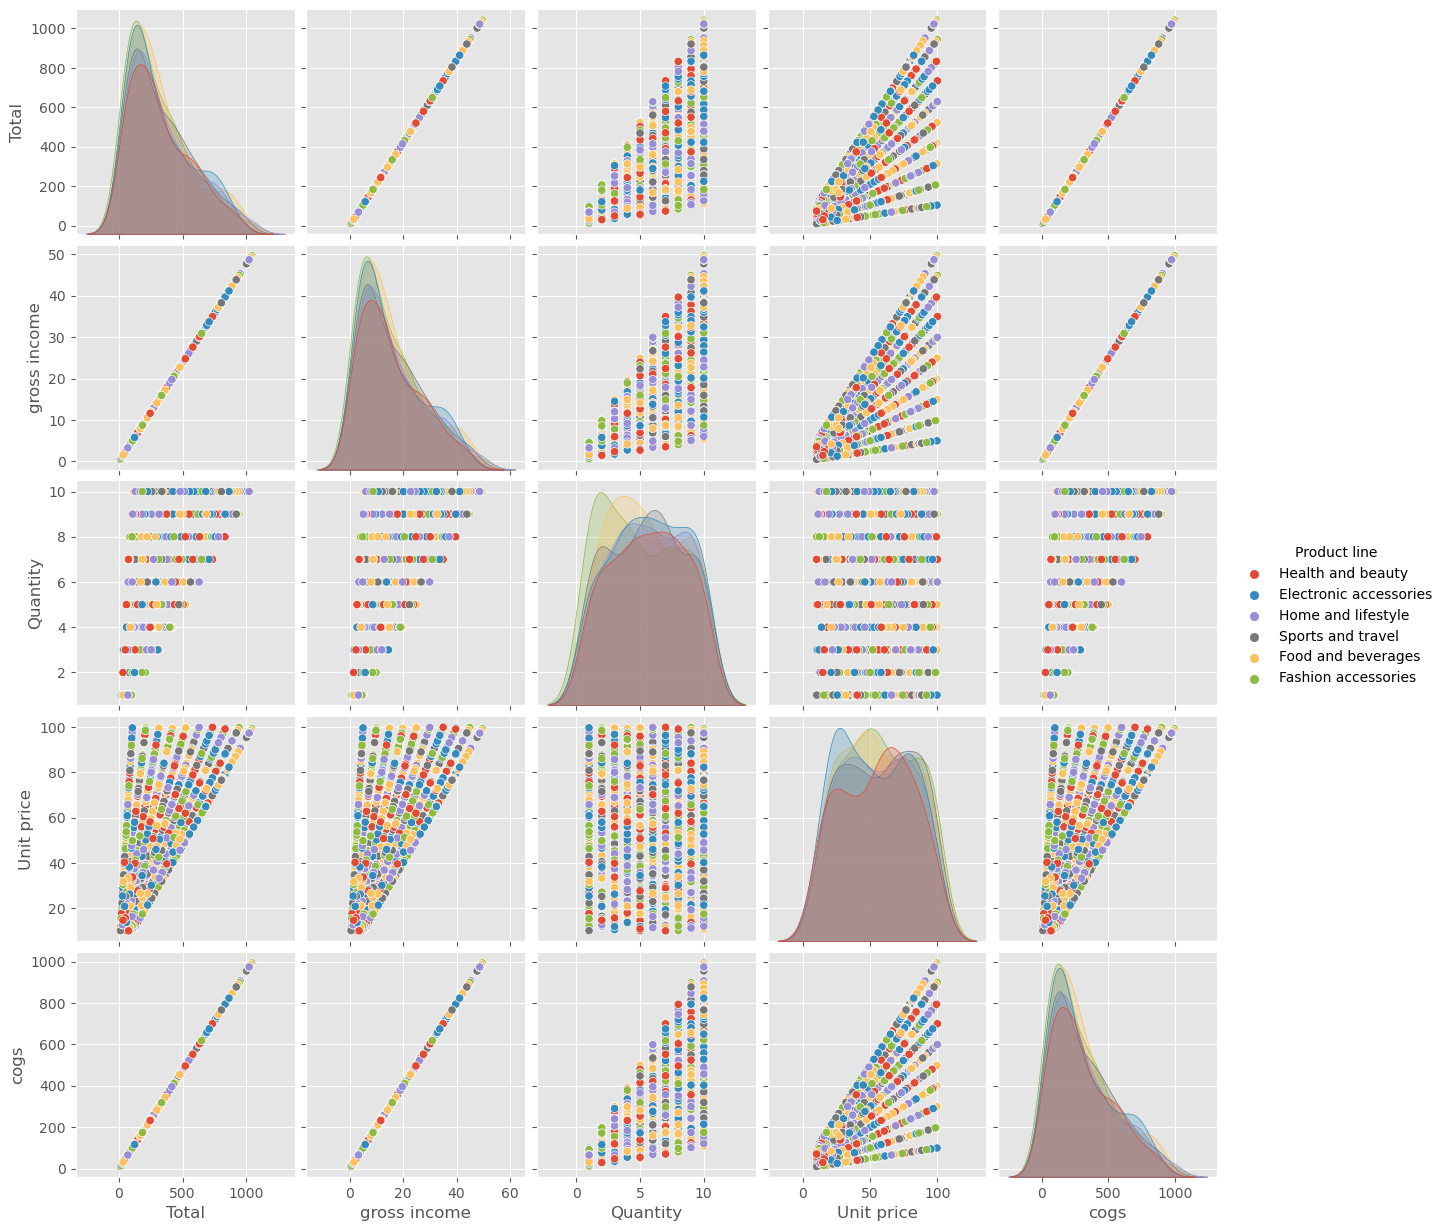

In [82]:
# Make a Seaborn pairplot to see columns plotted against one another
sns.pairplot(data, 
             vars = ["Total", "gross income", "Quantity", "Unit price", "cogs"],
             hue = 'Product line')
plt.show()

Here, one can note some expected trends for our dataset:
- Gross income goes up with total sales and the cost of production.
    - Although not necessarily with quantity.
- The unit price goes up with cost of production.
- The quantity is completely independent of other variables. 
- Different product lines don't seem to have a massive impact on sales and total revenues. 

We can further explore the relationships between variables by inspecting the correlations:

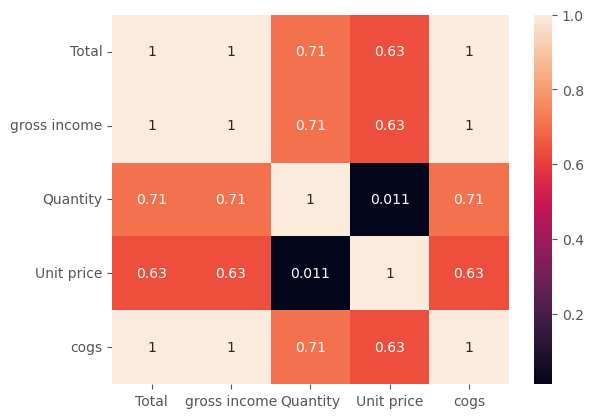

In [84]:
# Generate a sns heatmap of correlations:
data_correlation = data[["Total", "gross income", "Quantity", "Unit price", "cogs"]].corr()

sns.heatmap(data_correlation, annot = True)
plt.show()

Finally, as we want to inspect time-series data, we can isolate some relevant timeseries showcasing income over time:

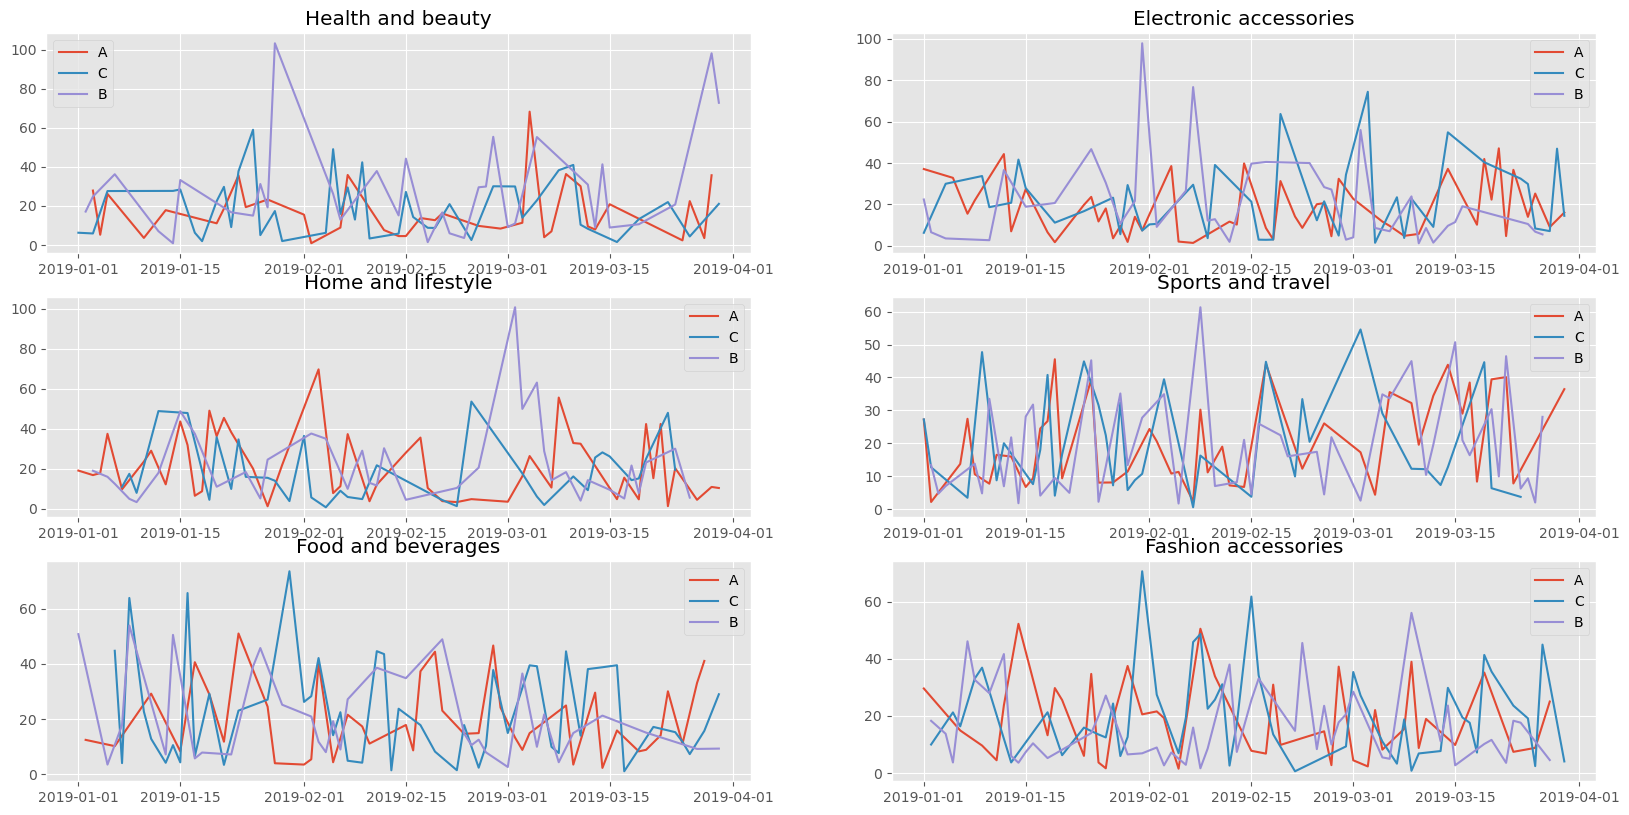

In [177]:
import datetime as dt

# Create a list of all branches in the dataset
branches = data['Branch'].unique()
products = data["Product line"].unique()
n, m = len(products), len(branches)

# Define a figure to plot onto
fig = plt.figure(figsize = (20, 20))

for j, prod in enumerate(products):
    plt.subplot(n, n//m, j+1)
    for i, branch in enumerate(branches):
        # isolate data of a product at the current branch for each day
        branch_data = data[(data["Branch"] == branch) & (data["Product line"] == prod)].groupby("Date").sum(numeric_only = True)
        
        # plot the product data for the current branch
        plt.plot(branch_data.index, branch_data["gross income"], label = branch)
        plt.title(prod)
        plt.legend()

plt.show()
